In [61]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from matplotlib.pyplot import imshow
import pandas as pd

import itertools
from itertools import cycle
from tqdm import tqdm
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import imageio
from sklearn.preprocessing import label_binarize
from collections import Counter

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split, KFold
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as k
import datetime
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
label_data  = pd.read_csv("/home/muhlabws4/Belgeler/UFC101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt",
                       sep = " ",
                       header=None)
label_data.columns=['index', 'labels']
label_data = label_data.drop(['index'], axis=1)
label_data.head()



,labels
0,ApplyEyeMakeup
1,ApplyLipstick
2,Archery
3,BabyCrawling
4,BalanceBeam


In [3]:
label_data.labels.values[0]

'ApplyEyeMakeup'

In [4]:
len(label_data)

101

In [5]:
path=[]
for label in label_data.labels.values:
    path.append('/home/muhlabws4/Belgeler/UFC101/UCF101/UCF-101/'+label+"/")
path[0]

'/home/muhlabws4/Belgeler/UFC101/UCF101/UCF-101/ApplyEyeMakeup/'

In [6]:
#Function for Feature Extraction
def feature_extraction(video_path):
    width=60
    height=60
    sequence_length=5
    frames_list=[]
    #Read the Video
    video_reader = cv2.VideoCapture(video_path)
    #get the frame count
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #Calculate the interval after which frames will be added to the list
    skip_interval = max(int(frame_count/sequence_length), 1)
    #iterate through video frames
    for counter in range(sequence_length):
        #Set the current frame postion of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        #Read the current frame 
        ret, frame = video_reader.read()
        if not ret:
            break;
        #Resize the image
        frame=cv2.resize(frame, (height, width))
        frame = frame/255
        #Append to the frame
        frames_list.append(frame)
    video_reader.release()
    #Return the Frames List
    return frames_list

In [7]:


#Function for loading video files, Process and store in a data set
def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    #Iterate through each foler corresponding to category
    for folder in datasets:
        for file in tqdm(os.listdir(folder)):
            #Get the path name for each video
            video_path = os.path.join(folder, file)
            #Extract the frames of the current video
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index+=1
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')



In [8]:


#Due to memory allocation problem. I will select last 60 video folders for classification
images, labels = load_video(path[41:])

100%|███████████████████████████████████| 128/128 [00:03<00:00, 34.02it/s]


In [9]:
images.shape, pd.Series(labels).shape

((7832, 5, 60, 60, 3), (7832,))

In [10]:
images.shape

(7832, 5, 60, 60, 3)

In [11]:
images[0]

array([[[[0.698 , 0.651 , 0.596 ],
         [0.702 , 0.655 , 0.6   ],
         [0.706 , 0.6587, 0.604 ],
         ...,
         [0.6743, 0.6157, 0.565 ],
         [0.6743, 0.6157, 0.565 ],
         [0.6743, 0.6157, 0.565 ]],

        [[0.698 , 0.651 , 0.596 ],
         [0.702 , 0.655 , 0.6   ],
         [0.706 , 0.6587, 0.604 ],
         ...,
         [0.6743, 0.6157, 0.565 ],
         [0.6743, 0.6157, 0.565 ],
         [0.6743, 0.6157, 0.565 ]],

        [[0.686 , 0.639 , 0.5845],
         [0.6943, 0.647 , 0.5923],
         [0.698 , 0.651 , 0.596 ],
         ...,
         [0.6743, 0.6157, 0.565 ],
         [0.6743, 0.6157, 0.565 ],
         [0.6743, 0.6157, 0.565 ]],

        ...,

        [[0.5527, 0.612 , 0.6235],
         [0.5527, 0.612 , 0.6235],
         [0.565 , 0.6235, 0.6353],
         ...,
         [0.6   , 0.647 , 0.6665],
         [0.604 , 0.651 , 0.6704],
         [0.604 , 0.651 , 0.6704]],

        [[0.569 , 0.6274, 0.639 ],
         [0.565 , 0.6235, 0.6353],
         [0.

In [12]:
#Train Test Split
x_train, x_test, y_train, y_test=train_test_split(images, labels, test_size=0.06, random_state=10)
x_train.shape, x_test.shape, np.array(y_train).shape, np.array(y_test).shape

((7362, 5, 60, 60, 3), (470, 5, 60, 60, 3), (7362,), (470,))

In [13]:
images[1].shape

(5, 60, 60, 3)

In [14]:
y_test.shape

(470,)

In [15]:
def videoview(index):
    fig = plt.figure(figsize=(32,8))
    for i,image in enumerate(images[index]):
        ax = plt.subplot(1,5,i+1)
        imshow(image[:,:,0])
        plt.title(label_data.labels.values[labels[index]+41],fontsize=21)


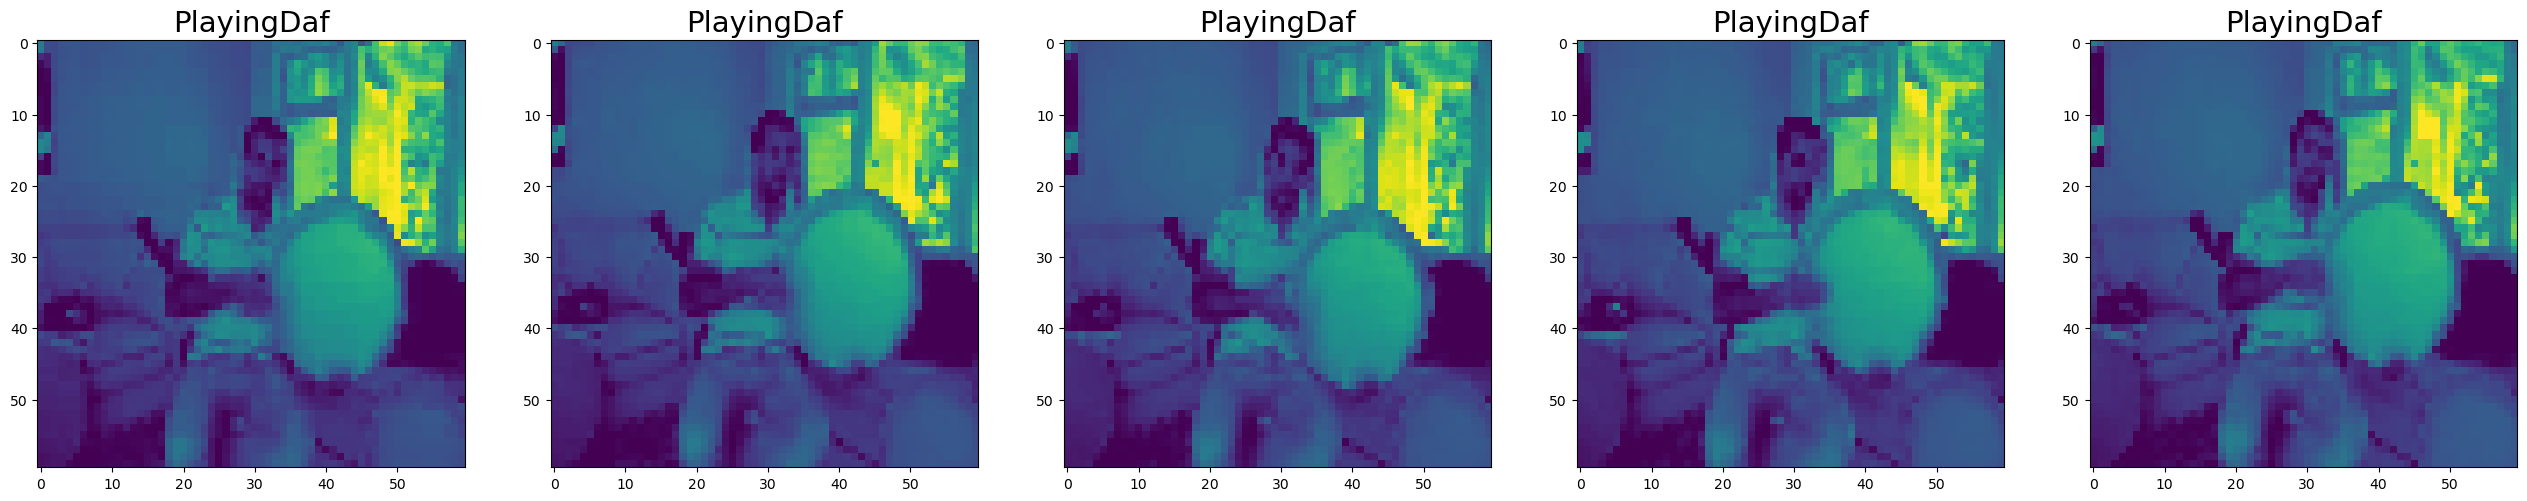

In [16]:
random_video_index = np.random.randint(0,len(images))
videoview(random_video_index)

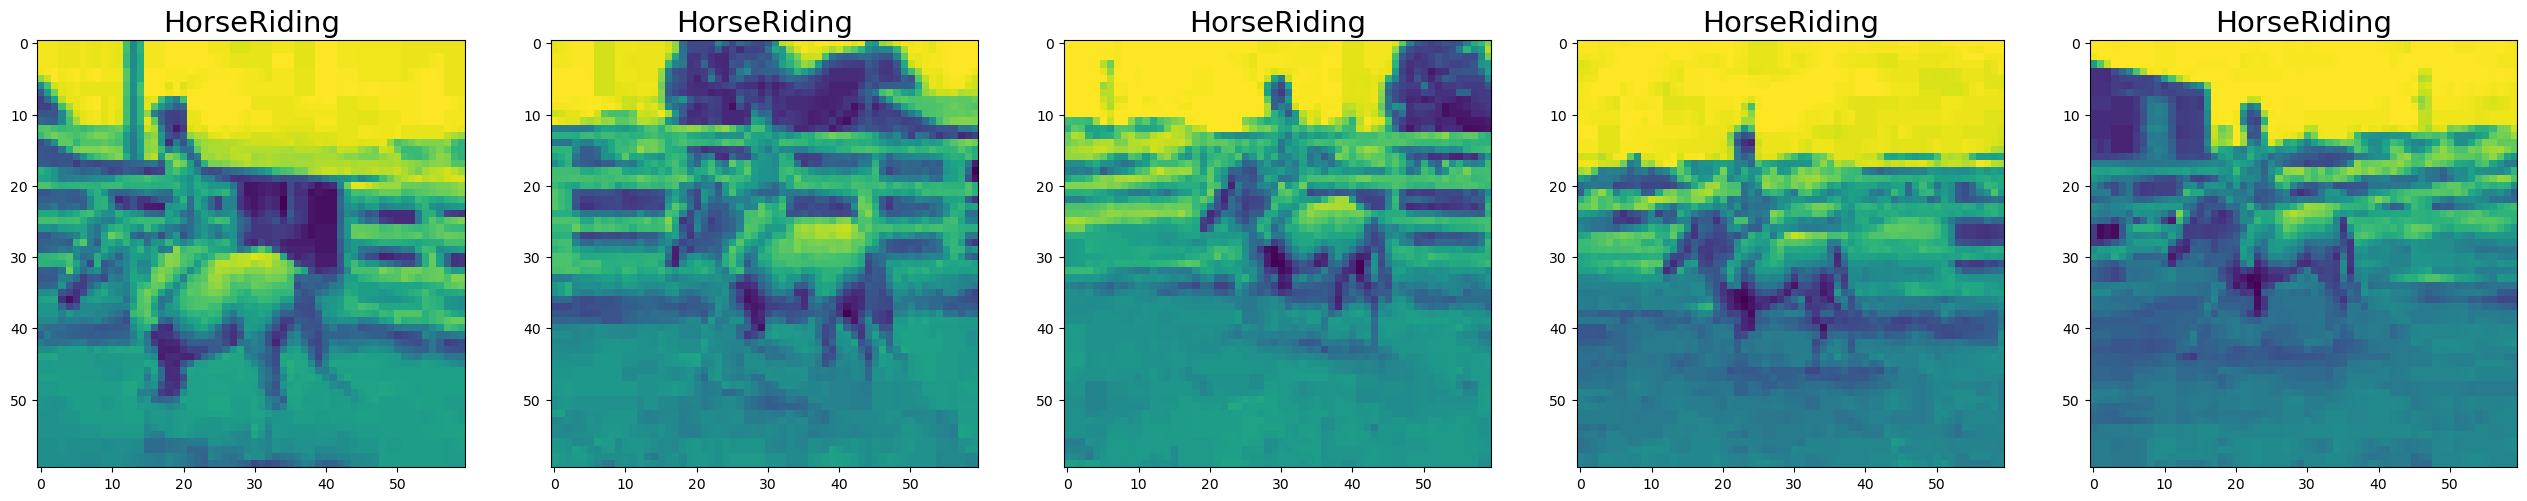

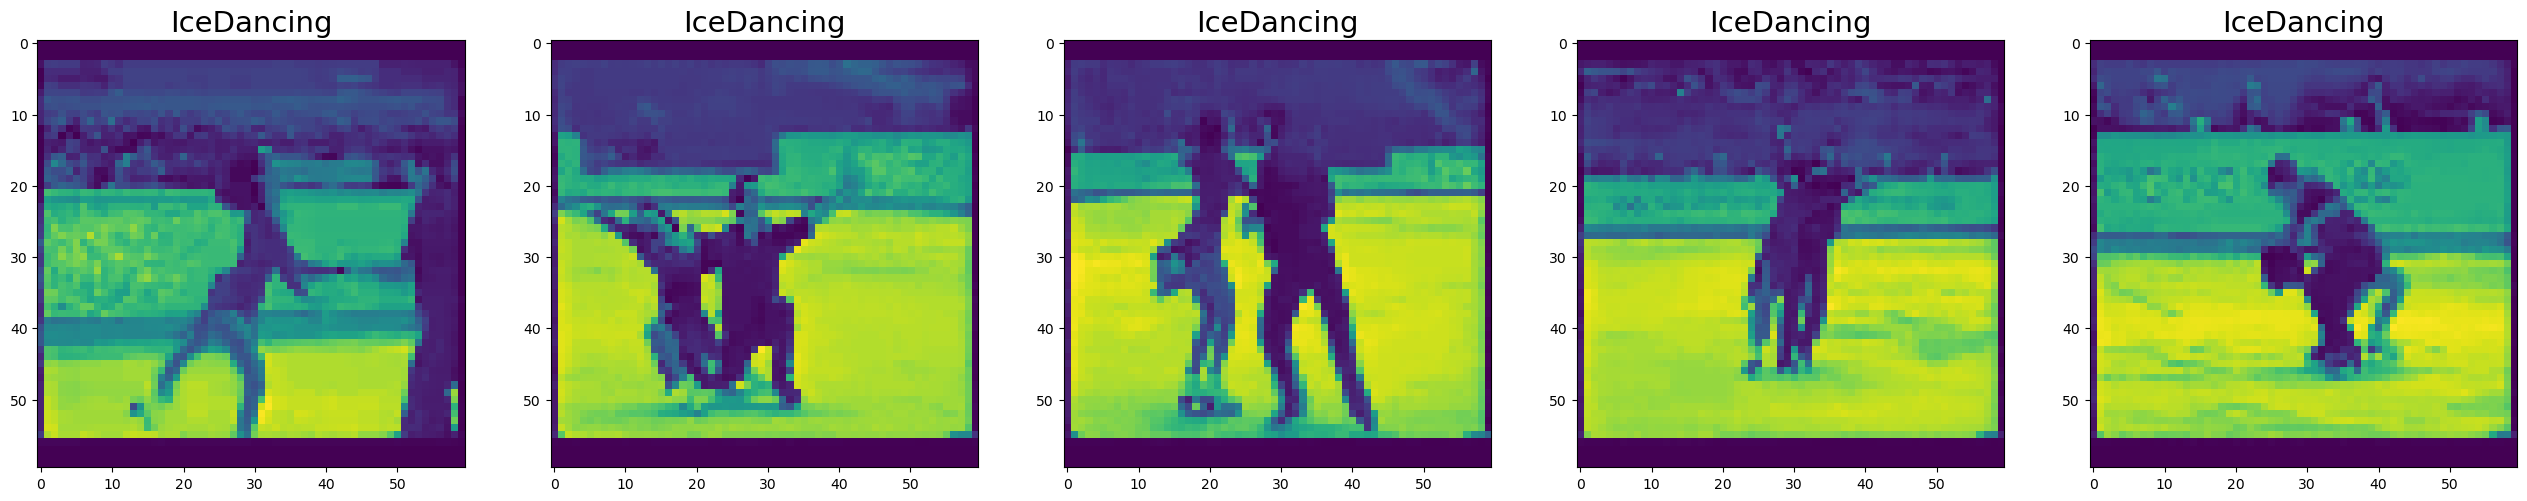

In [17]:
videoview(2)
videoview(290)

In [60]:
model = Sequential()

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2, input_shape=(x_train.shape[1],x_train.shape[2], x_train.shape[3], 3)))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(Flatten())
          
model.add(Dense(60, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 5, 58, 58, 16)     11008     
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 5, 29, 29, 16)     0         
 g3D)                                                            
                                                                 
 time_distributed_4 (TimeDi  (None, 5, 29, 29, 16)     0         
 stributed)                                                      
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 5, 27, 27, 16)     18496     
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 5, 14, 14, 16)     0         
 g3D)                                                            
                                                      

In [19]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [20]:
y_train

array([ 8, 50, 44, ..., 35, 55,  9], dtype=int8)

In [21]:
class_weight = Counter(y_train)
class_weight

Counter({8: 115,
         50: 159,
         44: 102,
         2: 148,
         45: 108,
         20: 149,
         6: 139,
         7: 131,
         10: 116,
         33: 110,
         21: 155,
         30: 96,
         37: 135,
         40: 96,
         46: 119,
         1: 115,
         54: 96,
         17: 156,
         34: 129,
         23: 151,
         29: 147,
         35: 124,
         47: 123,
         43: 128,
         49: 96,
         4: 115,
         57: 125,
         27: 112,
         42: 139,
         25: 93,
         5: 114,
         24: 105,
         53: 128,
         13: 102,
         18: 139,
         58: 147,
         51: 118,
         26: 141,
         0: 154,
         52: 114,
         14: 127,
         39: 124,
         48: 134,
         9: 126,
         56: 115,
         41: 104,
         12: 126,
         36: 154,
         38: 114,
         59: 113,
         28: 96,
         31: 108,
         15: 107,
         22: 96,
         19: 152,
         3: 109,
         

In [22]:
def cross_validation(model, X, y, n_splits=4, epochs=5, batch_size=32):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    historyy = []
    for train_inx, val_inx in kfold.split(X):
        X_train, X_val = X[train_inx], X[val_inx]
        y_train, y_val = y[train_inx], y[val_inx]
        
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
        es = EarlyStopping(monitor='loss', patience=5)
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[es], class_weight=class_weight)
        historyy.append(history.history)
    return historyy


In [24]:
#Model training
history = cross_validation(model, x_train, to_categorical(y_train), batch_size=8, epochs=40)


Epoch 1/40


2023-08-14 15:35:43.453833: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/dropout_3/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


691/691 - 38s - loss: 282.7419 - accuracy: 0.3706 - 38s/epoch - 54ms/step
Epoch 2/40
691/691 - 32s - loss: 258.1232 - accuracy: 0.4173 - 32s/epoch - 47ms/step
Epoch 3/40
691/691 - 33s - loss: 240.4585 - accuracy: 0.4548 - 33s/epoch - 47ms/step
Epoch 4/40
691/691 - 32s - loss: 222.2563 - accuracy: 0.4854 - 32s/epoch - 47ms/step
Epoch 5/40
691/691 - 32s - loss: 207.9921 - accuracy: 0.5140 - 32s/epoch - 47ms/step
Epoch 6/40
691/691 - 32s - loss: 197.1985 - accuracy: 0.5363 - 32s/epoch - 47ms/step
Epoch 7/40
691/691 - 33s - loss: 187.8029 - accuracy: 0.5571 - 33s/epoch - 48ms/step
Epoch 8/40
691/691 - 32s - loss: 173.8329 - accuracy: 0.5838 - 32s/epoch - 47ms/step
Epoch 9/40
691/691 - 33s - loss: 166.7552 - accuracy: 0.6084 - 33s/epoch - 47ms/step
Epoch 10/40
691/691 - 33s - loss: 159.1341 - accuracy: 0.6171 - 33s/epoch - 47ms/step
Epoch 11/40
691/691 - 32s - loss: 152.7229 - accuracy: 0.6258 - 32s/epoch - 46ms/step
Epoch 12/40
691/691 - 32s - loss: 144.0123 - accuracy: 0.6470 - 32s/epoch 

2023-08-14 15:57:26.559265: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/dropout_3/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


691/691 - 39s - loss: 114.2343 - accuracy: 0.7466 - 39s/epoch - 57ms/step
Epoch 2/40
691/691 - 32s - loss: 103.7884 - accuracy: 0.7537 - 32s/epoch - 47ms/step
Epoch 3/40
691/691 - 33s - loss: 97.4302 - accuracy: 0.7645 - 33s/epoch - 48ms/step
Epoch 4/40
691/691 - 32s - loss: 91.5665 - accuracy: 0.7794 - 32s/epoch - 47ms/step
Epoch 5/40
691/691 - 33s - loss: 91.0757 - accuracy: 0.7758 - 33s/epoch - 48ms/step
Epoch 6/40
691/691 - 32s - loss: 85.2986 - accuracy: 0.7834 - 32s/epoch - 47ms/step
Epoch 7/40
691/691 - 33s - loss: 84.2961 - accuracy: 0.7837 - 33s/epoch - 47ms/step
Epoch 8/40
691/691 - 33s - loss: 81.8659 - accuracy: 0.7944 - 33s/epoch - 48ms/step
Epoch 9/40
691/691 - 32s - loss: 78.3942 - accuracy: 0.8004 - 32s/epoch - 46ms/step
Epoch 10/40
691/691 - 33s - loss: 75.9330 - accuracy: 0.8031 - 33s/epoch - 47ms/step
Epoch 11/40
691/691 - 33s - loss: 75.8743 - accuracy: 0.8040 - 33s/epoch - 48ms/step
Epoch 12/40
691/691 - 33s - loss: 72.9861 - accuracy: 0.8133 - 33s/epoch - 47ms/ste

2023-08-14 16:19:20.981617: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/dropout_3/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


691/691 - 39s - loss: 78.8680 - accuracy: 0.8082 - 39s/epoch - 56ms/step
Epoch 2/40
691/691 - 32s - loss: 71.2556 - accuracy: 0.8147 - 32s/epoch - 46ms/step
Epoch 3/40
691/691 - 33s - loss: 67.2177 - accuracy: 0.8296 - 33s/epoch - 47ms/step
Epoch 4/40
691/691 - 32s - loss: 62.7996 - accuracy: 0.8396 - 32s/epoch - 46ms/step
Epoch 5/40
691/691 - 33s - loss: 62.7739 - accuracy: 0.8379 - 33s/epoch - 48ms/step
Epoch 6/40
691/691 - 33s - loss: 59.3011 - accuracy: 0.8479 - 33s/epoch - 47ms/step
Epoch 7/40
691/691 - 33s - loss: 59.1933 - accuracy: 0.8421 - 33s/epoch - 47ms/step
Epoch 8/40
691/691 - 33s - loss: 55.8567 - accuracy: 0.8526 - 33s/epoch - 48ms/step
Epoch 9/40
691/691 - 33s - loss: 57.2383 - accuracy: 0.8495 - 33s/epoch - 47ms/step
Epoch 10/40
691/691 - 33s - loss: 54.6491 - accuracy: 0.8544 - 33s/epoch - 48ms/step
Epoch 11/40
691/691 - 32s - loss: 55.6249 - accuracy: 0.8506 - 32s/epoch - 47ms/step
Epoch 12/40
691/691 - 33s - loss: 53.5603 - accuracy: 0.8568 - 33s/epoch - 48ms/step


2023-08-14 16:35:00.132942: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/dropout_3/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


691/691 - 39s - loss: 61.0579 - accuracy: 0.8499 - 39s/epoch - 56ms/step
Epoch 2/40
691/691 - 35s - loss: 57.7853 - accuracy: 0.8535 - 35s/epoch - 51ms/step
Epoch 3/40
691/691 - 37s - loss: 53.5276 - accuracy: 0.8620 - 37s/epoch - 53ms/step
Epoch 4/40
691/691 - 33s - loss: 52.7246 - accuracy: 0.8649 - 33s/epoch - 48ms/step
Epoch 5/40
691/691 - 33s - loss: 51.7696 - accuracy: 0.8676 - 33s/epoch - 47ms/step
Epoch 6/40
691/691 - 36s - loss: 50.0089 - accuracy: 0.8705 - 36s/epoch - 52ms/step
Epoch 7/40
691/691 - 33s - loss: 50.8993 - accuracy: 0.8629 - 33s/epoch - 48ms/step
Epoch 8/40
691/691 - 33s - loss: 46.6786 - accuracy: 0.8738 - 33s/epoch - 48ms/step
Epoch 9/40
691/691 - 33s - loss: 45.2667 - accuracy: 0.8772 - 33s/epoch - 48ms/step
Epoch 10/40
691/691 - 33s - loss: 46.4282 - accuracy: 0.8792 - 33s/epoch - 48ms/step
Epoch 11/40
691/691 - 33s - loss: 46.3883 - accuracy: 0.8760 - 33s/epoch - 47ms/step
Epoch 12/40
691/691 - 33s - loss: 44.9826 - accuracy: 0.8801 - 33s/epoch - 47ms/step


In [31]:
#compile model
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [32]:
#Model training
#es = EarlyStopping(monitor='val_loss', patience=5)
#history = model.fit(x_train, to_categorical(y_train), batch_size=8, epochs=50, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

In [32]:
print(history[0])
#print(history[1])
#print(history[2])
#print(history[3])

{'loss': [282.74188232421875, 258.1231994628906, 240.45852661132812, 222.25628662109375, 207.99209594726562, 197.19851684570312, 187.80291748046875, 173.83285522460938, 166.75523376464844, 159.13412475585938, 152.72291564941406, 144.0122528076172, 139.51837158203125, 134.52305603027344, 128.51834106445312, 122.85244750976562, 120.8705825805664, 117.80451965332031, 116.89226531982422, 110.6797103881836, 106.40113830566406, 102.09436798095703, 100.07483673095703, 98.01860809326172, 98.50533294677734, 94.11983489990234, 91.6865463256836, 89.27751159667969, 88.07088470458984, 88.06722259521484, 85.13677978515625, 82.4582290649414, 81.251708984375, 77.79137420654297, 78.041015625, 76.05030059814453, 78.36196899414062, 75.06334686279297, 72.47525787353516, 74.42540740966797], 'accuracy': [0.37058502435684204, 0.41731569170951843, 0.45480892062187195, 0.48541930317878723, 0.5140373110771179, 0.5363158583641052, 0.5571454167366028, 0.5837710499763489, 0.608404278755188, 0.617098331451416, 0.62

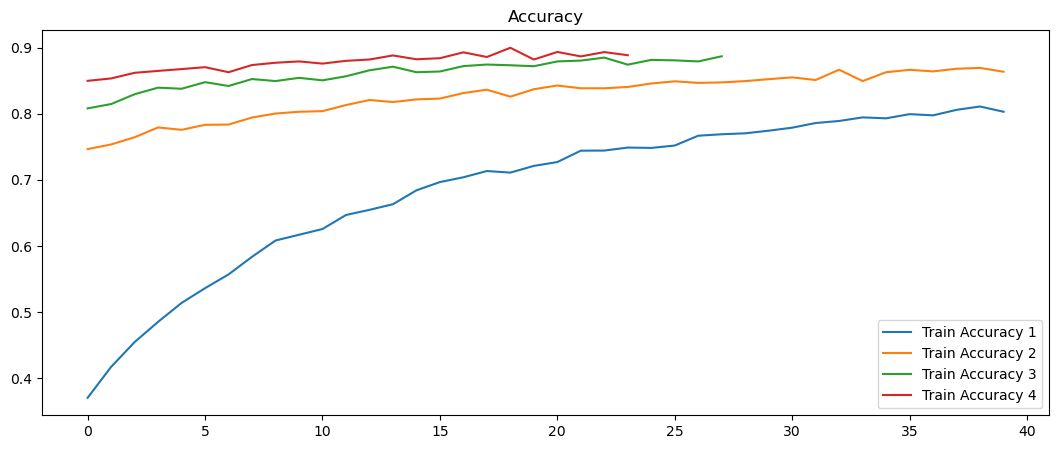

In [41]:
plt.figure(figsize=(13,5))
plt.title("Accuracy")
plt.plot(history[0]['accuracy'], label='Train Accuracy 1')
plt.plot(history[1]['accuracy'], label='Train Accuracy 2')
plt.plot(history[2]['accuracy'], label='Train Accuracy 3')
plt.plot(history[3]['accuracy'], label='Train Accuracy 4')
plt.legend(loc='best')
plt.show()

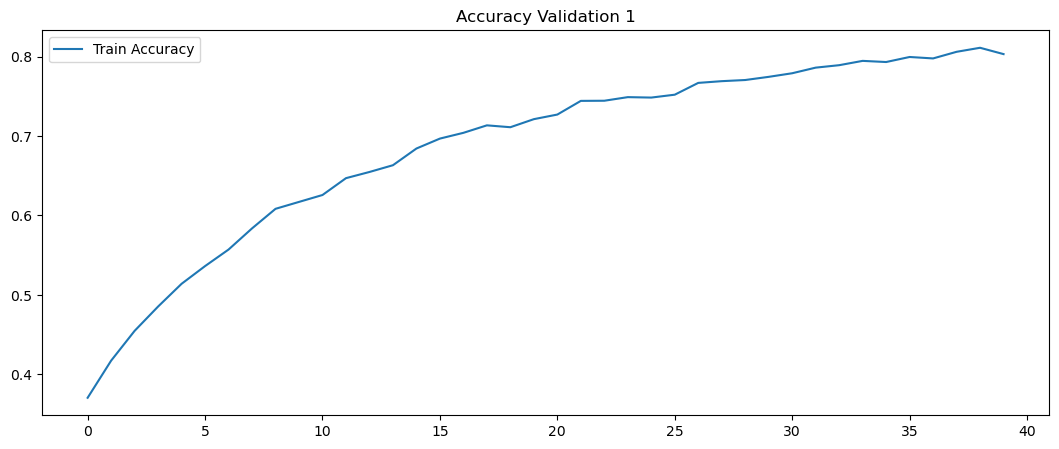

In [45]:
plt.figure(figsize=(13,5))
plt.title("Accuracy Validation 1")
plt.plot(history[0]['accuracy'], label='Train Accuracy')
plt.legend(loc='best')
plt.show()

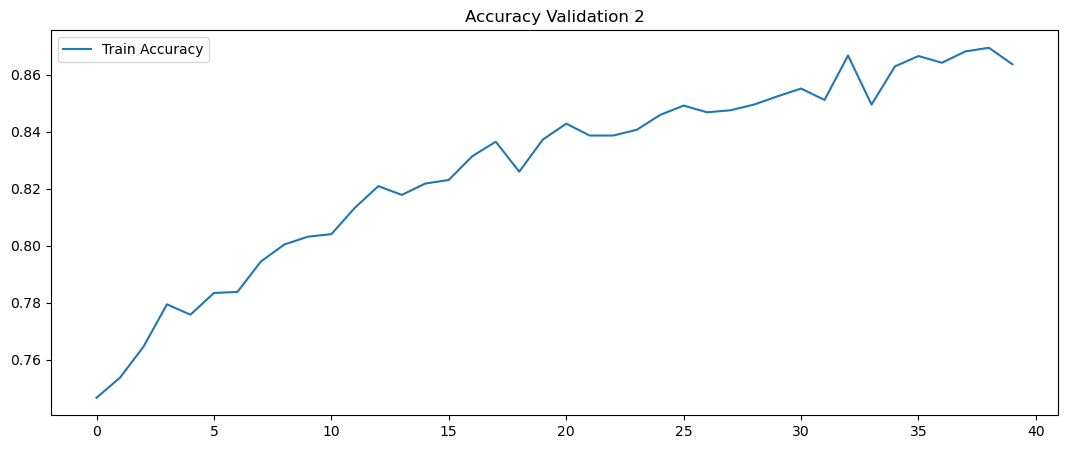

In [44]:
plt.figure(figsize=(13,5))
plt.title("Accuracy Validation 2")
plt.plot(history[1]['accuracy'], label='Train Accuracy')
plt.legend(loc='best')
plt.show()

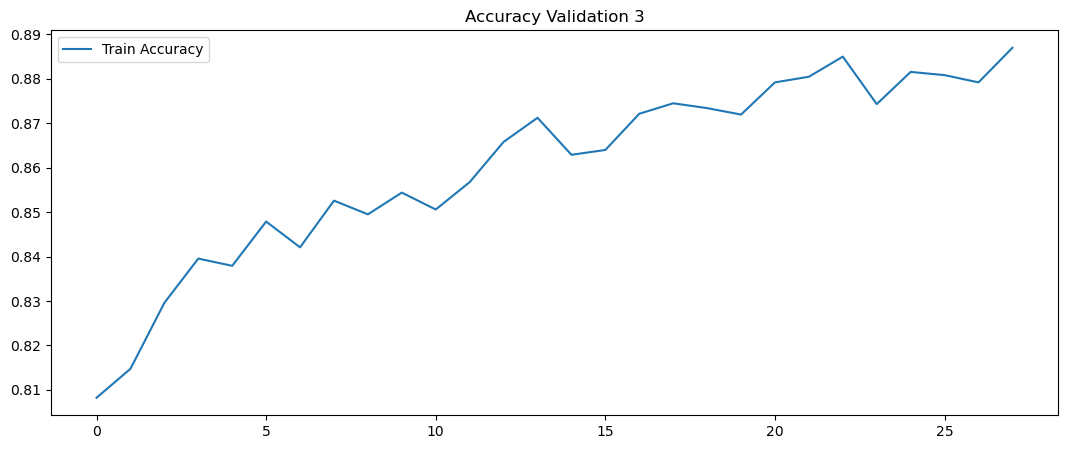

In [43]:
plt.figure(figsize=(13,5))
plt.title("Accuracy Validation 3")
plt.plot(history[2]['accuracy'], label='Train Accuracy')
plt.legend(loc='best')
plt.show()

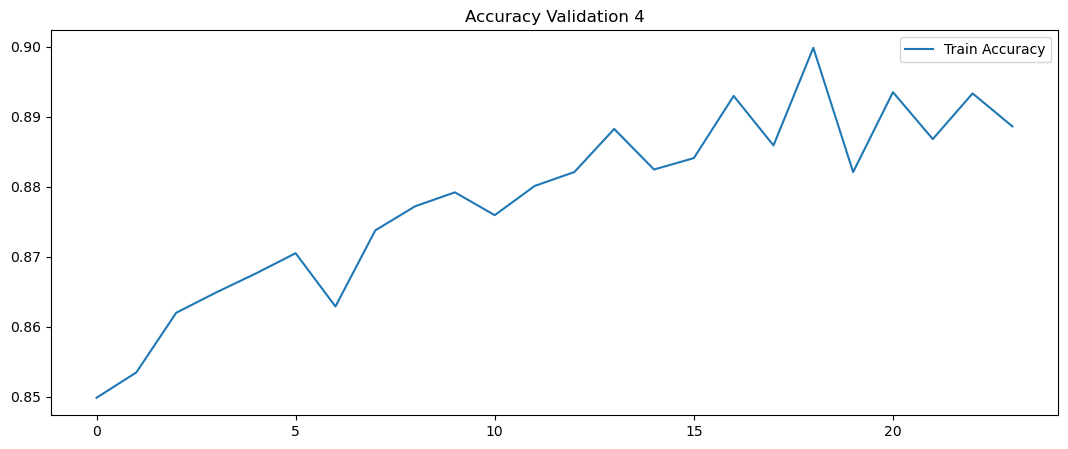

In [42]:
plt.figure(figsize=(13,5))
plt.title("Accuracy Validation 4")
plt.plot(history[3]['accuracy'], label='Train Accuracy')
plt.legend(loc='best')
plt.show()

In [46]:
y_pred = model.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))

15/15 [==============================] - 1s 31ms/step


In [47]:
y_pred.shape

(470, 60)

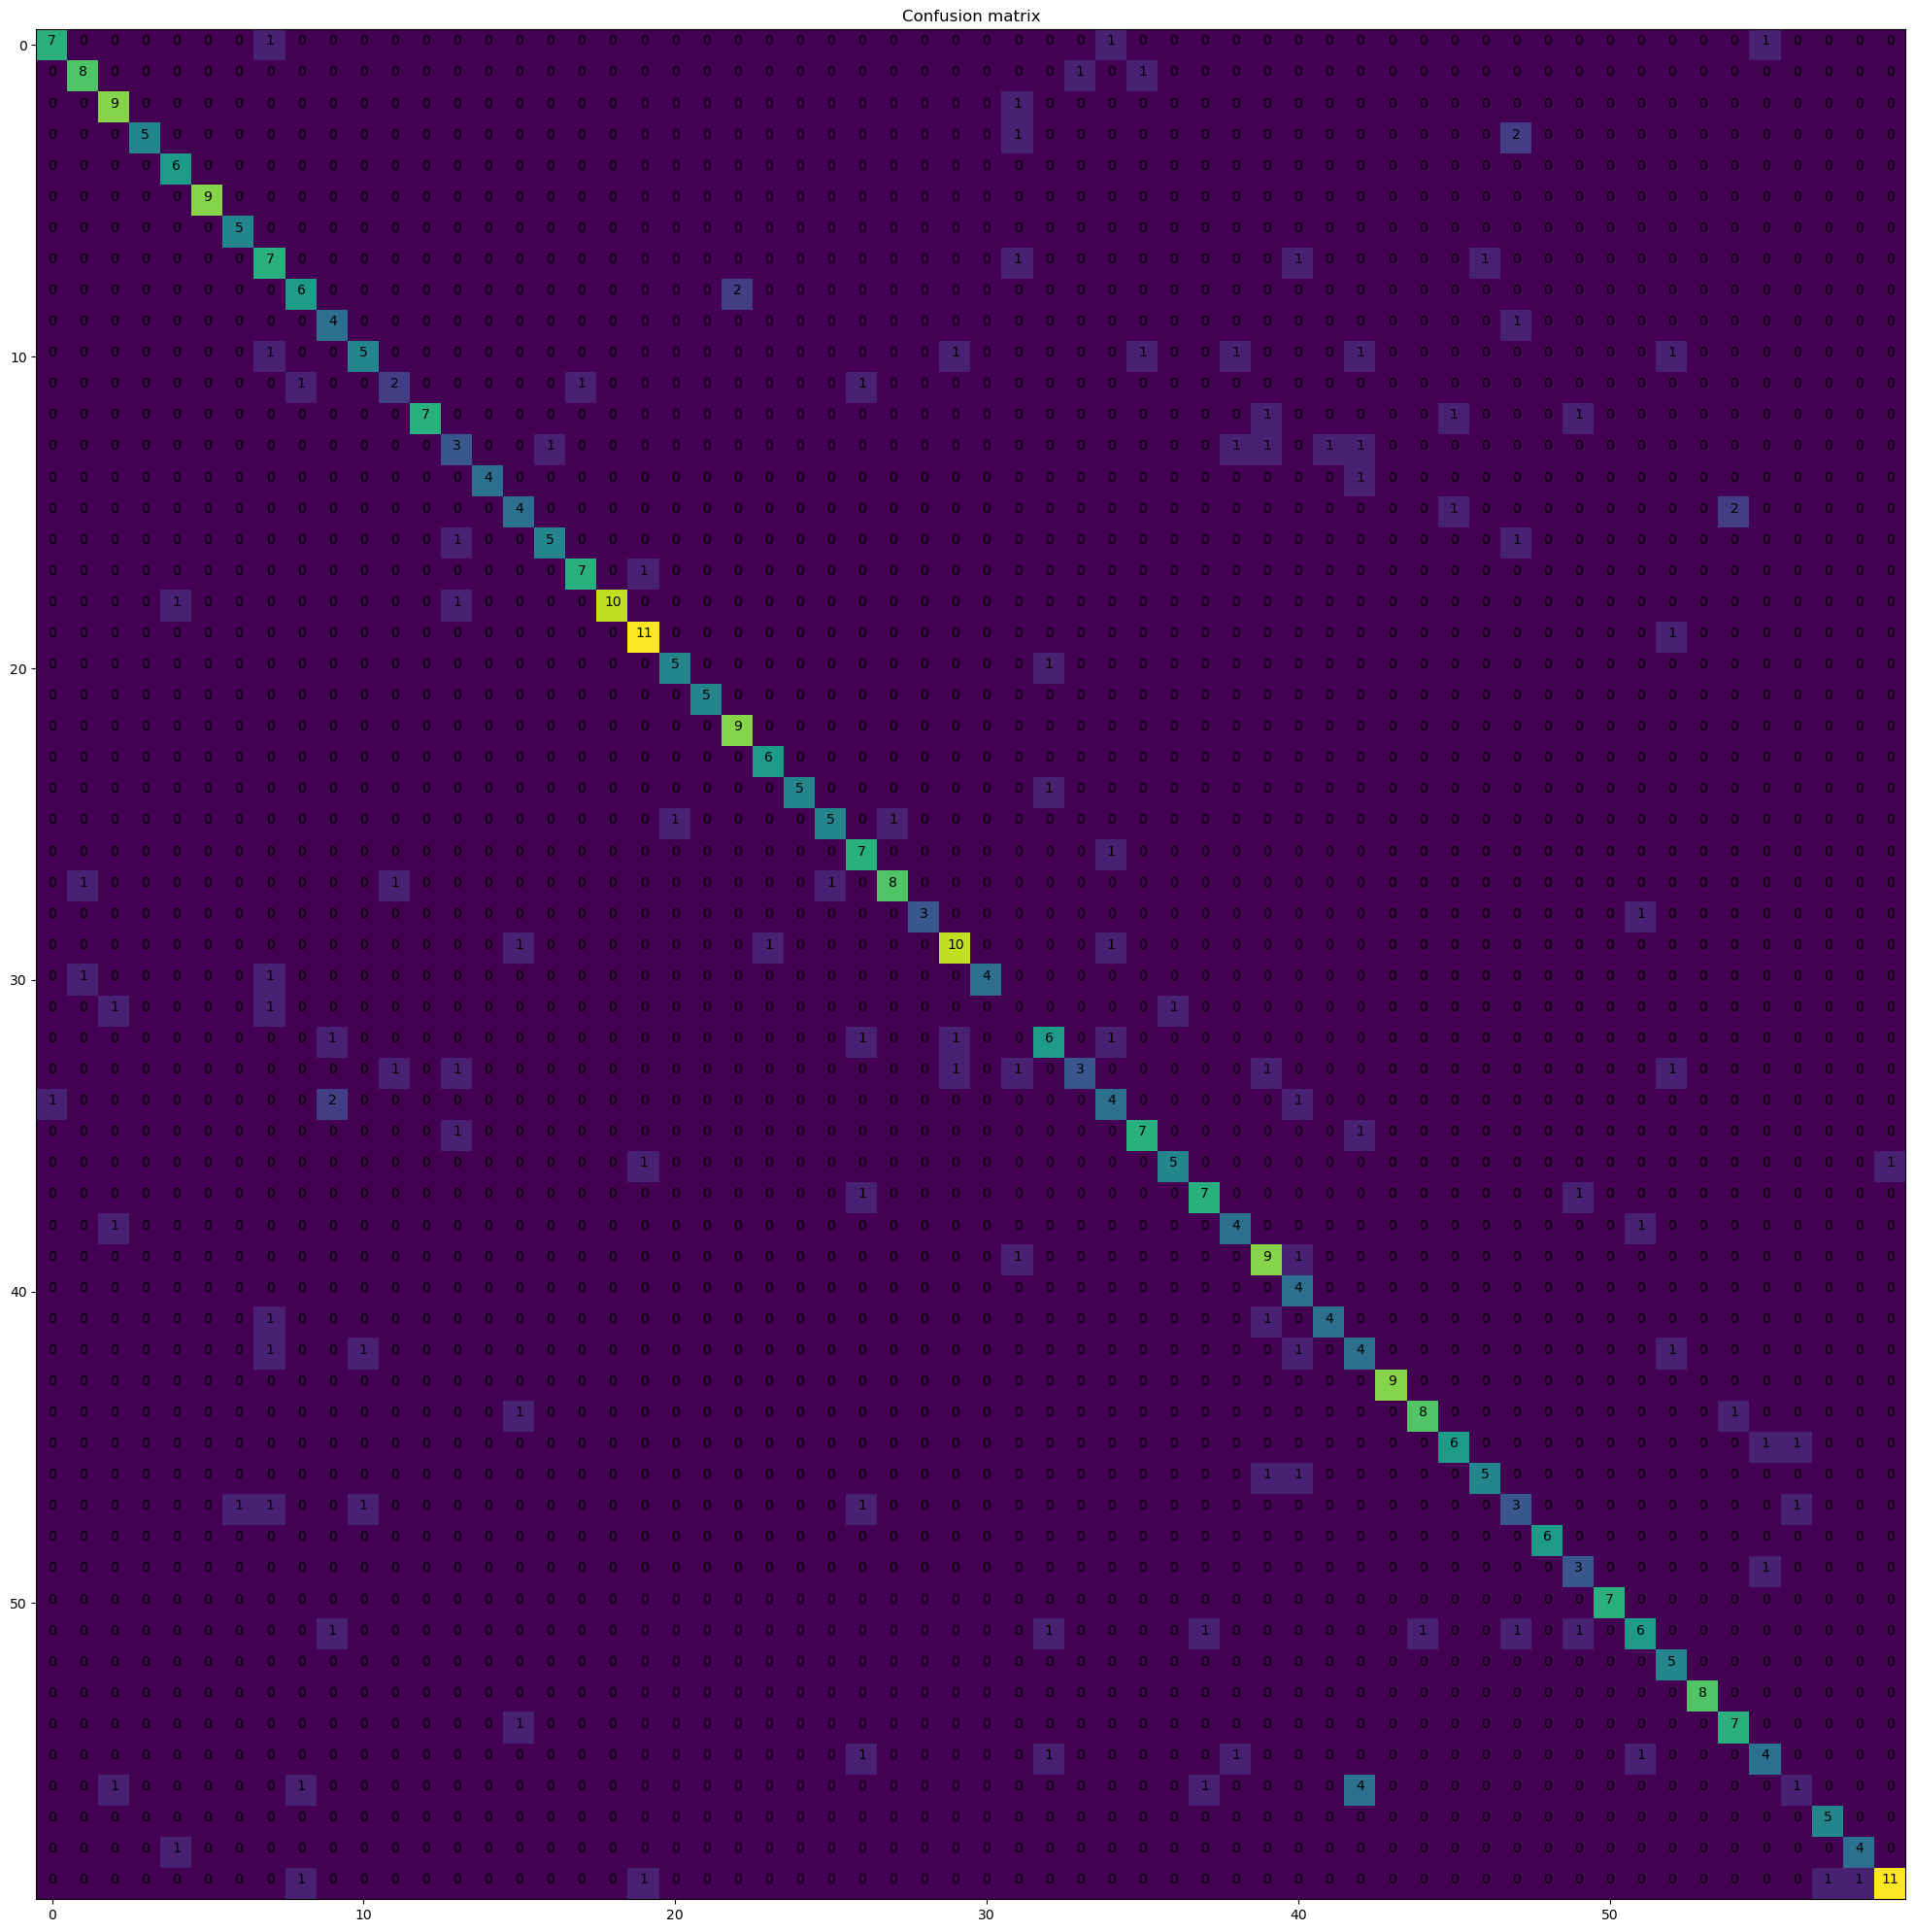

In [48]:
plt.figure(figsize=(25,25))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

In [62]:
model.save('CNN_Model_CrossVal_Balance_UCF101.h5')

In [50]:
predicted_classes = np.array(predicted_classes)
predicted_classes.shape

(470,)

In [51]:
labels.shape

(7832,)

In [52]:
def videoviewTest(index):
    fig = plt.figure(figsize=(32,8))
    for i,image in enumerate(x_test[index]):
        ax = plt.subplot(1,5,i+1)
        imshow(image[:,:,0])
        a=label_data.labels.values[y_test[index]+41]
        b=label_data.labels.values[predicted_classes[index]+41]
        plt.title(a,fontsize=27)
        if a==b:
            plt.xlabel(b,fontsize=27, color='green')
        else:
            plt.xlabel(b,fontsize=27, color='red')

In [2]:
videoviewTest(10)
videoviewTest(60)


NameError: name 'videoviewTest' is not defined

In [54]:
print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.80      0.80      0.80        10
           2       0.75      0.90      0.82        10
           3       1.00      0.62      0.77         8
           4       0.75      1.00      0.86         6
           5       1.00      1.00      1.00         9
           6       0.83      1.00      0.91         5
           7       0.50      0.70      0.58        10
           8       0.67      0.75      0.71         8
           9       0.50      0.80      0.62         5
          10       0.71      0.45      0.56        11
          11       0.50      0.40      0.44         5
          12       1.00      0.70      0.82        10
          13       0.43      0.38      0.40         8
          14       1.00      0.80      0.89         5
          15       0.57      0.57      0.57         7
          16       0.83      0.71      0.77         7
          17       0.88    

In [55]:
def plot_roc_curve(y_test, y_pred, class_index):
    n_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test, classes=np.arange(n_classes))
    y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
  
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    #plt.figure(figsize=(10,5))
    plt.figure(dpi=600)
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy", linestyle=":", linewidth=4,)
    
    """
    colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)
    """
    
    
    plt.plot(fpr[class_index], tpr[class_index], color='darkgreen', lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(class_index, roc_auc[class_index]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) curve")
    plt.legend()

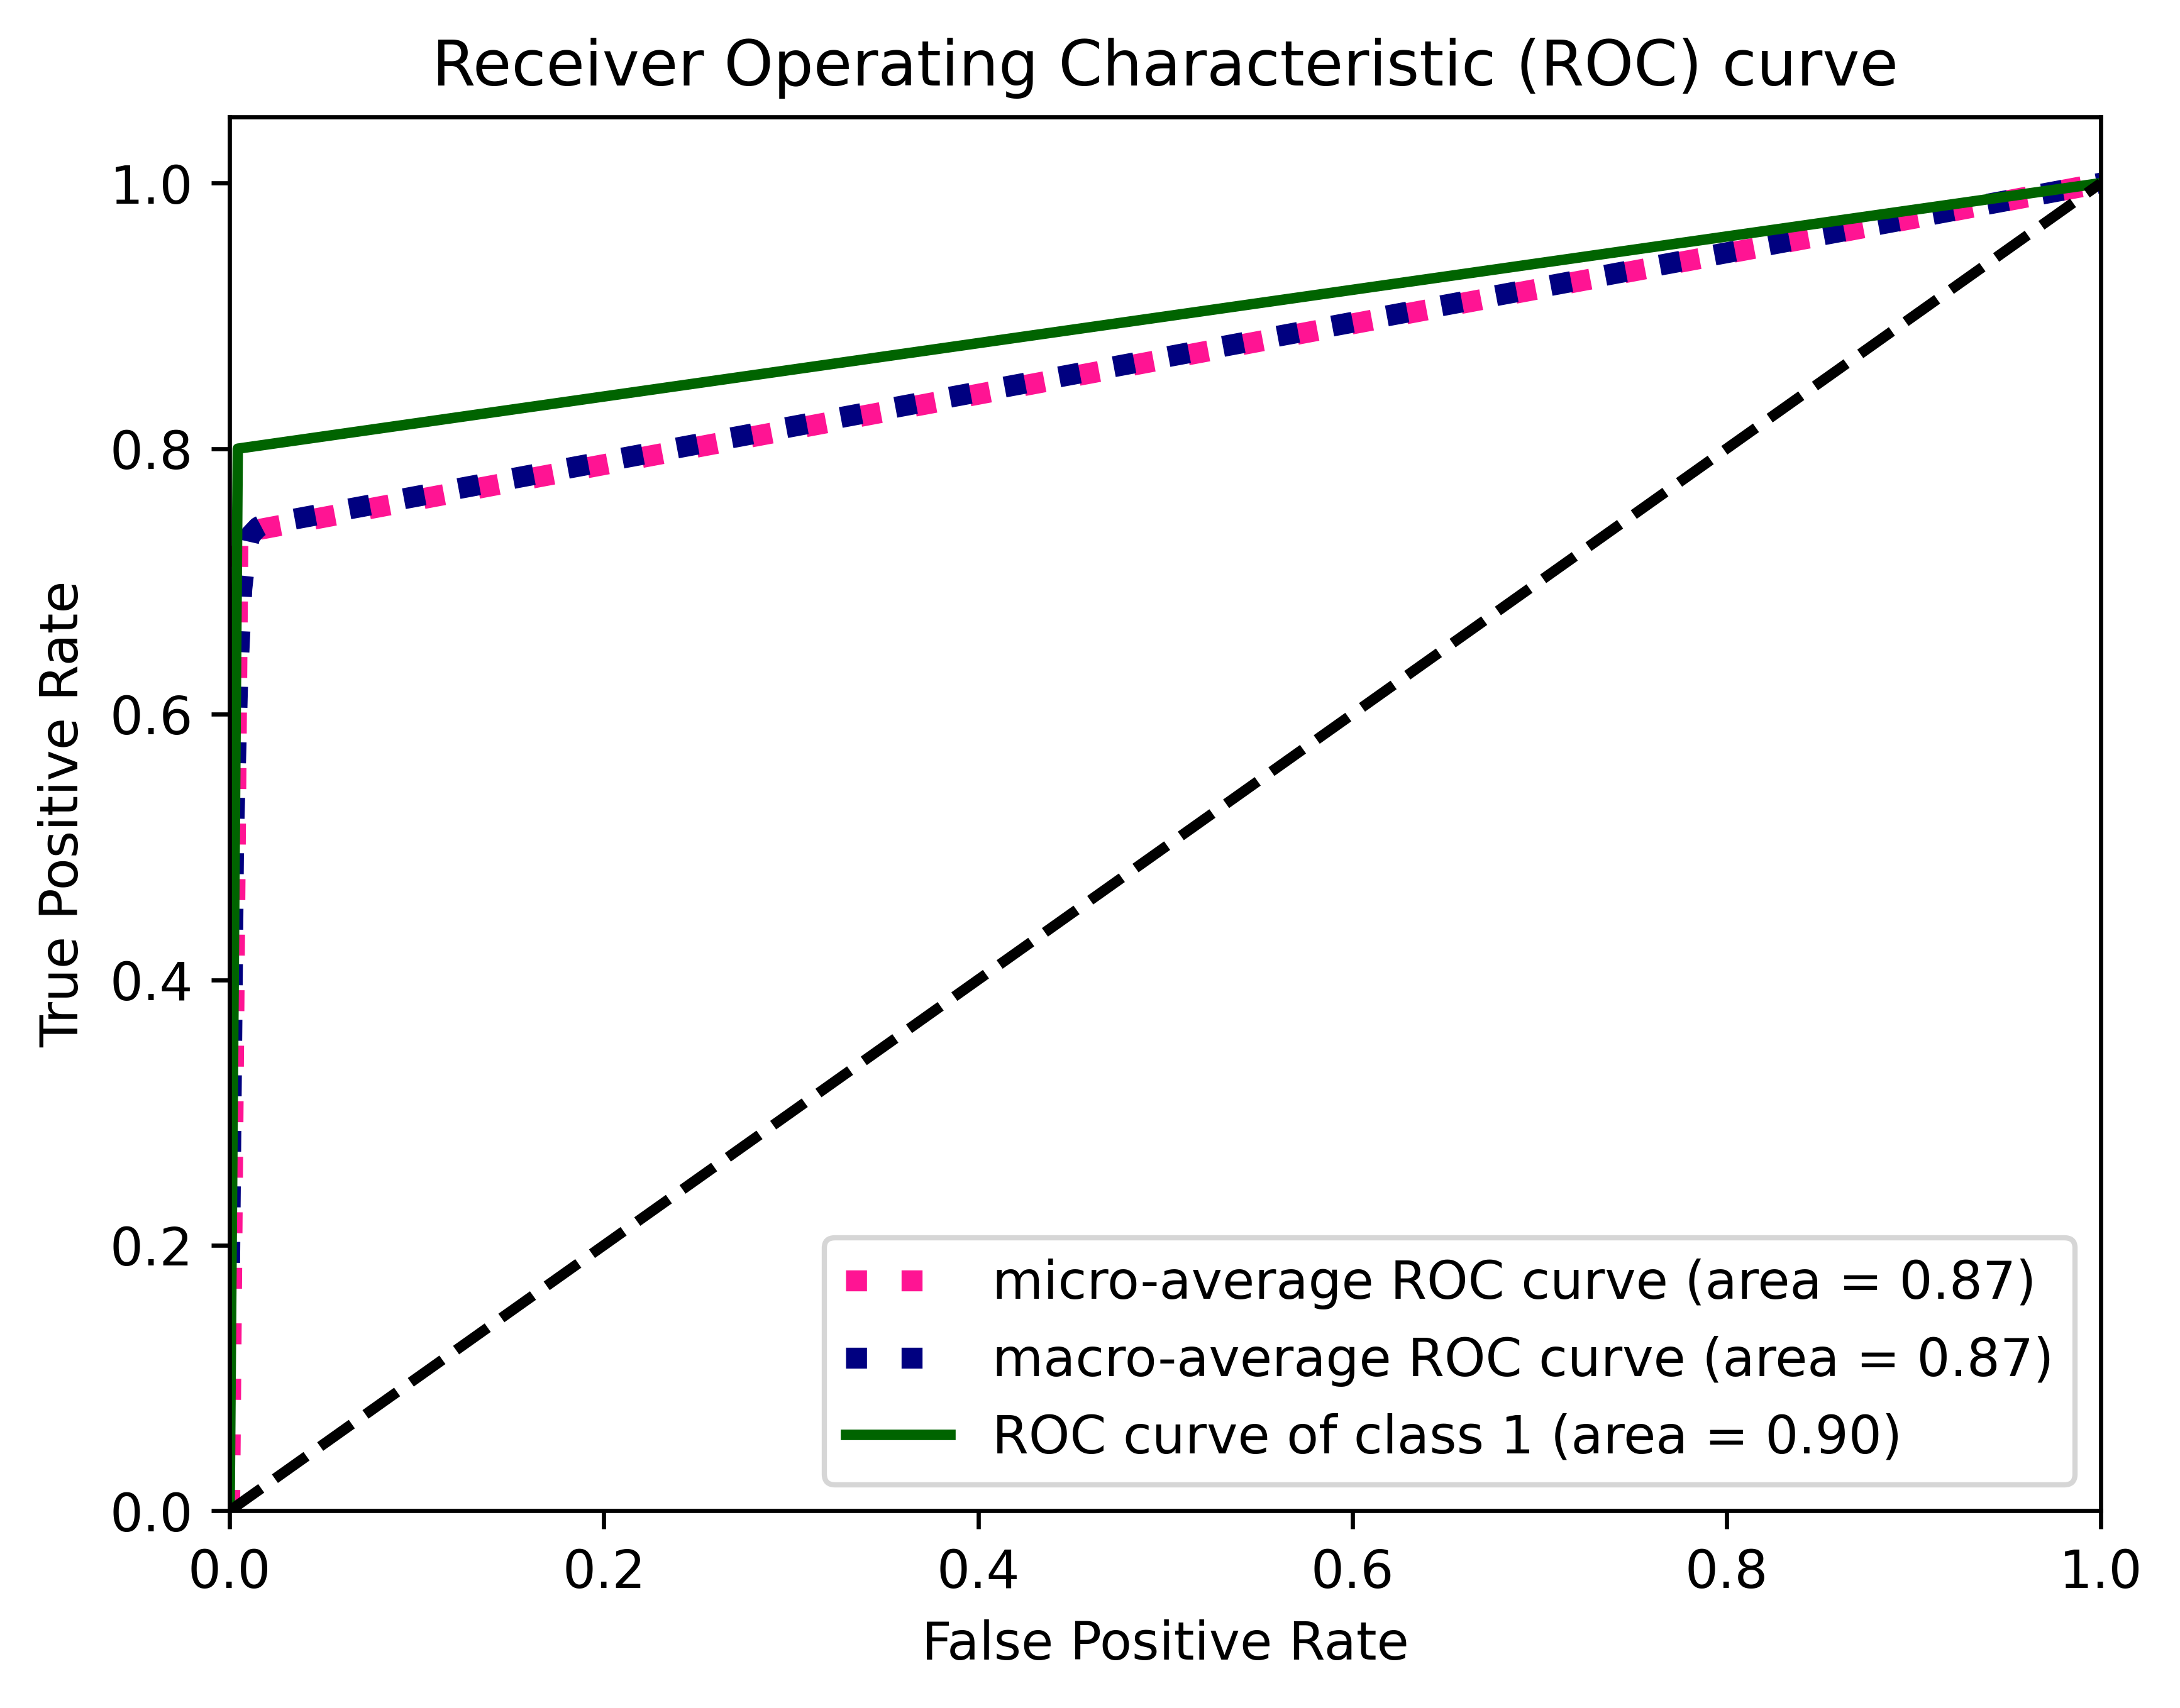

In [56]:
plot_roc_curve(y_test, predicted_classes,1)

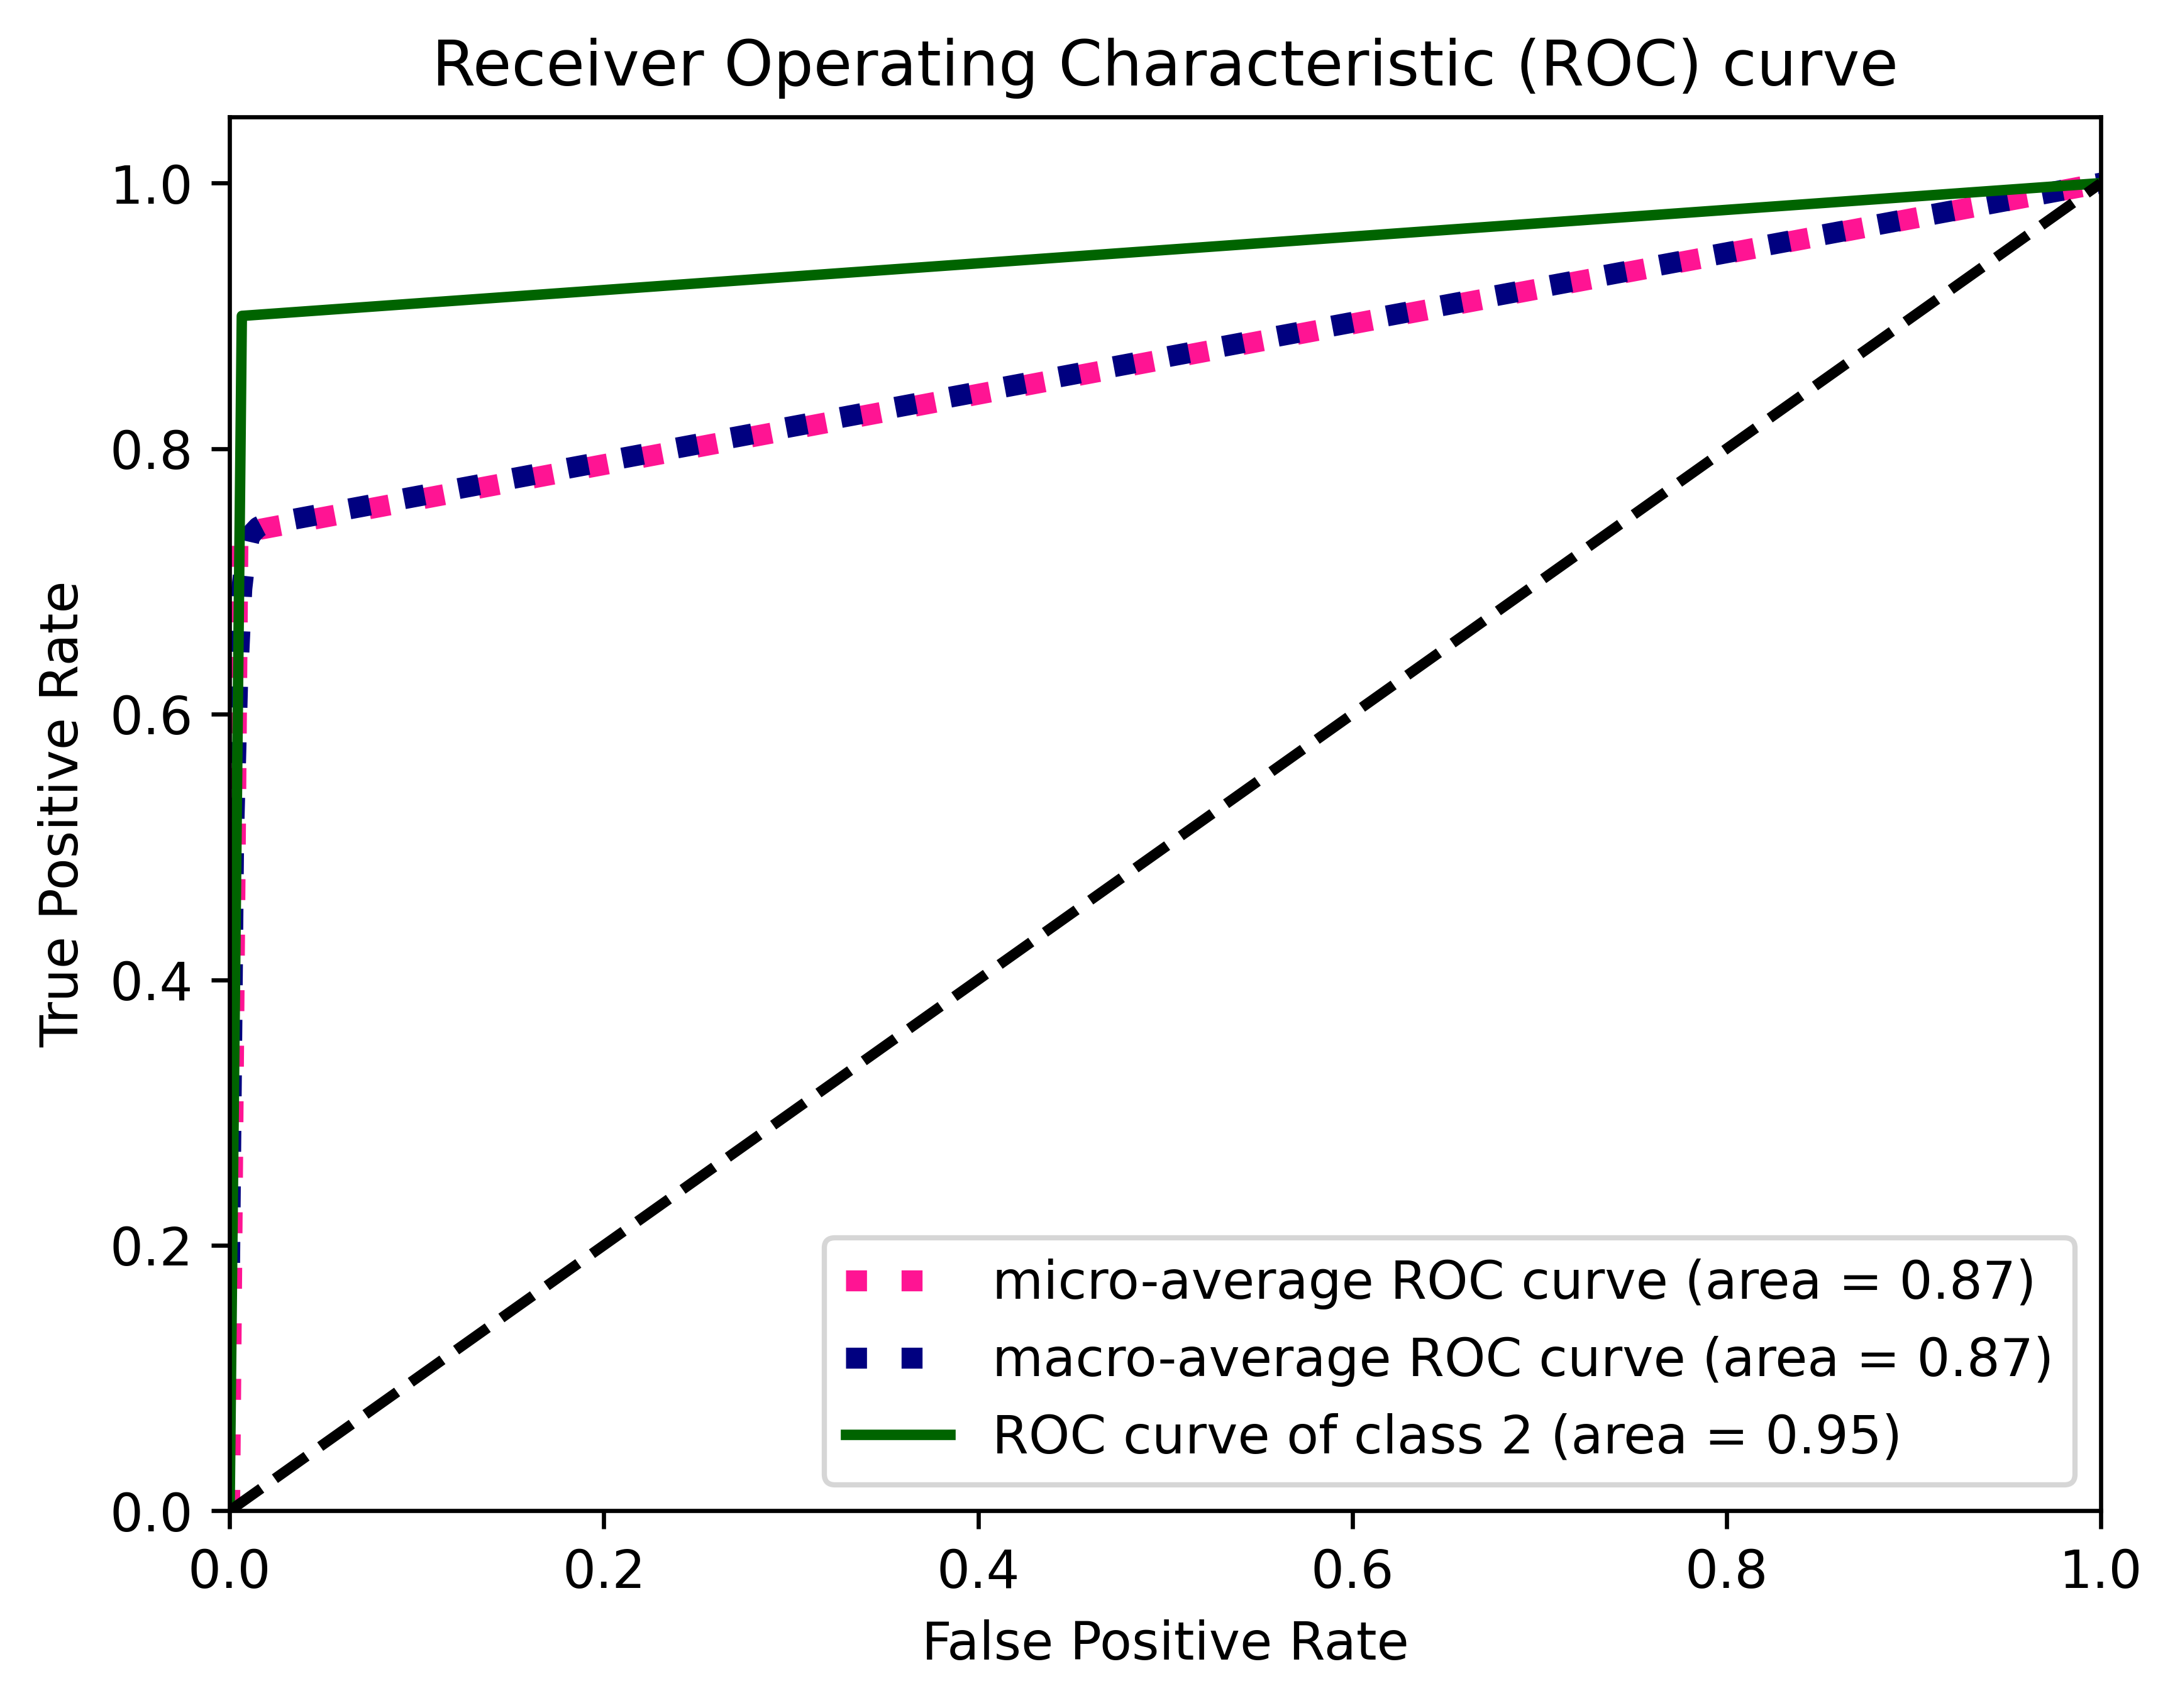

In [57]:
plot_roc_curve(y_test, predicted_classes,2)

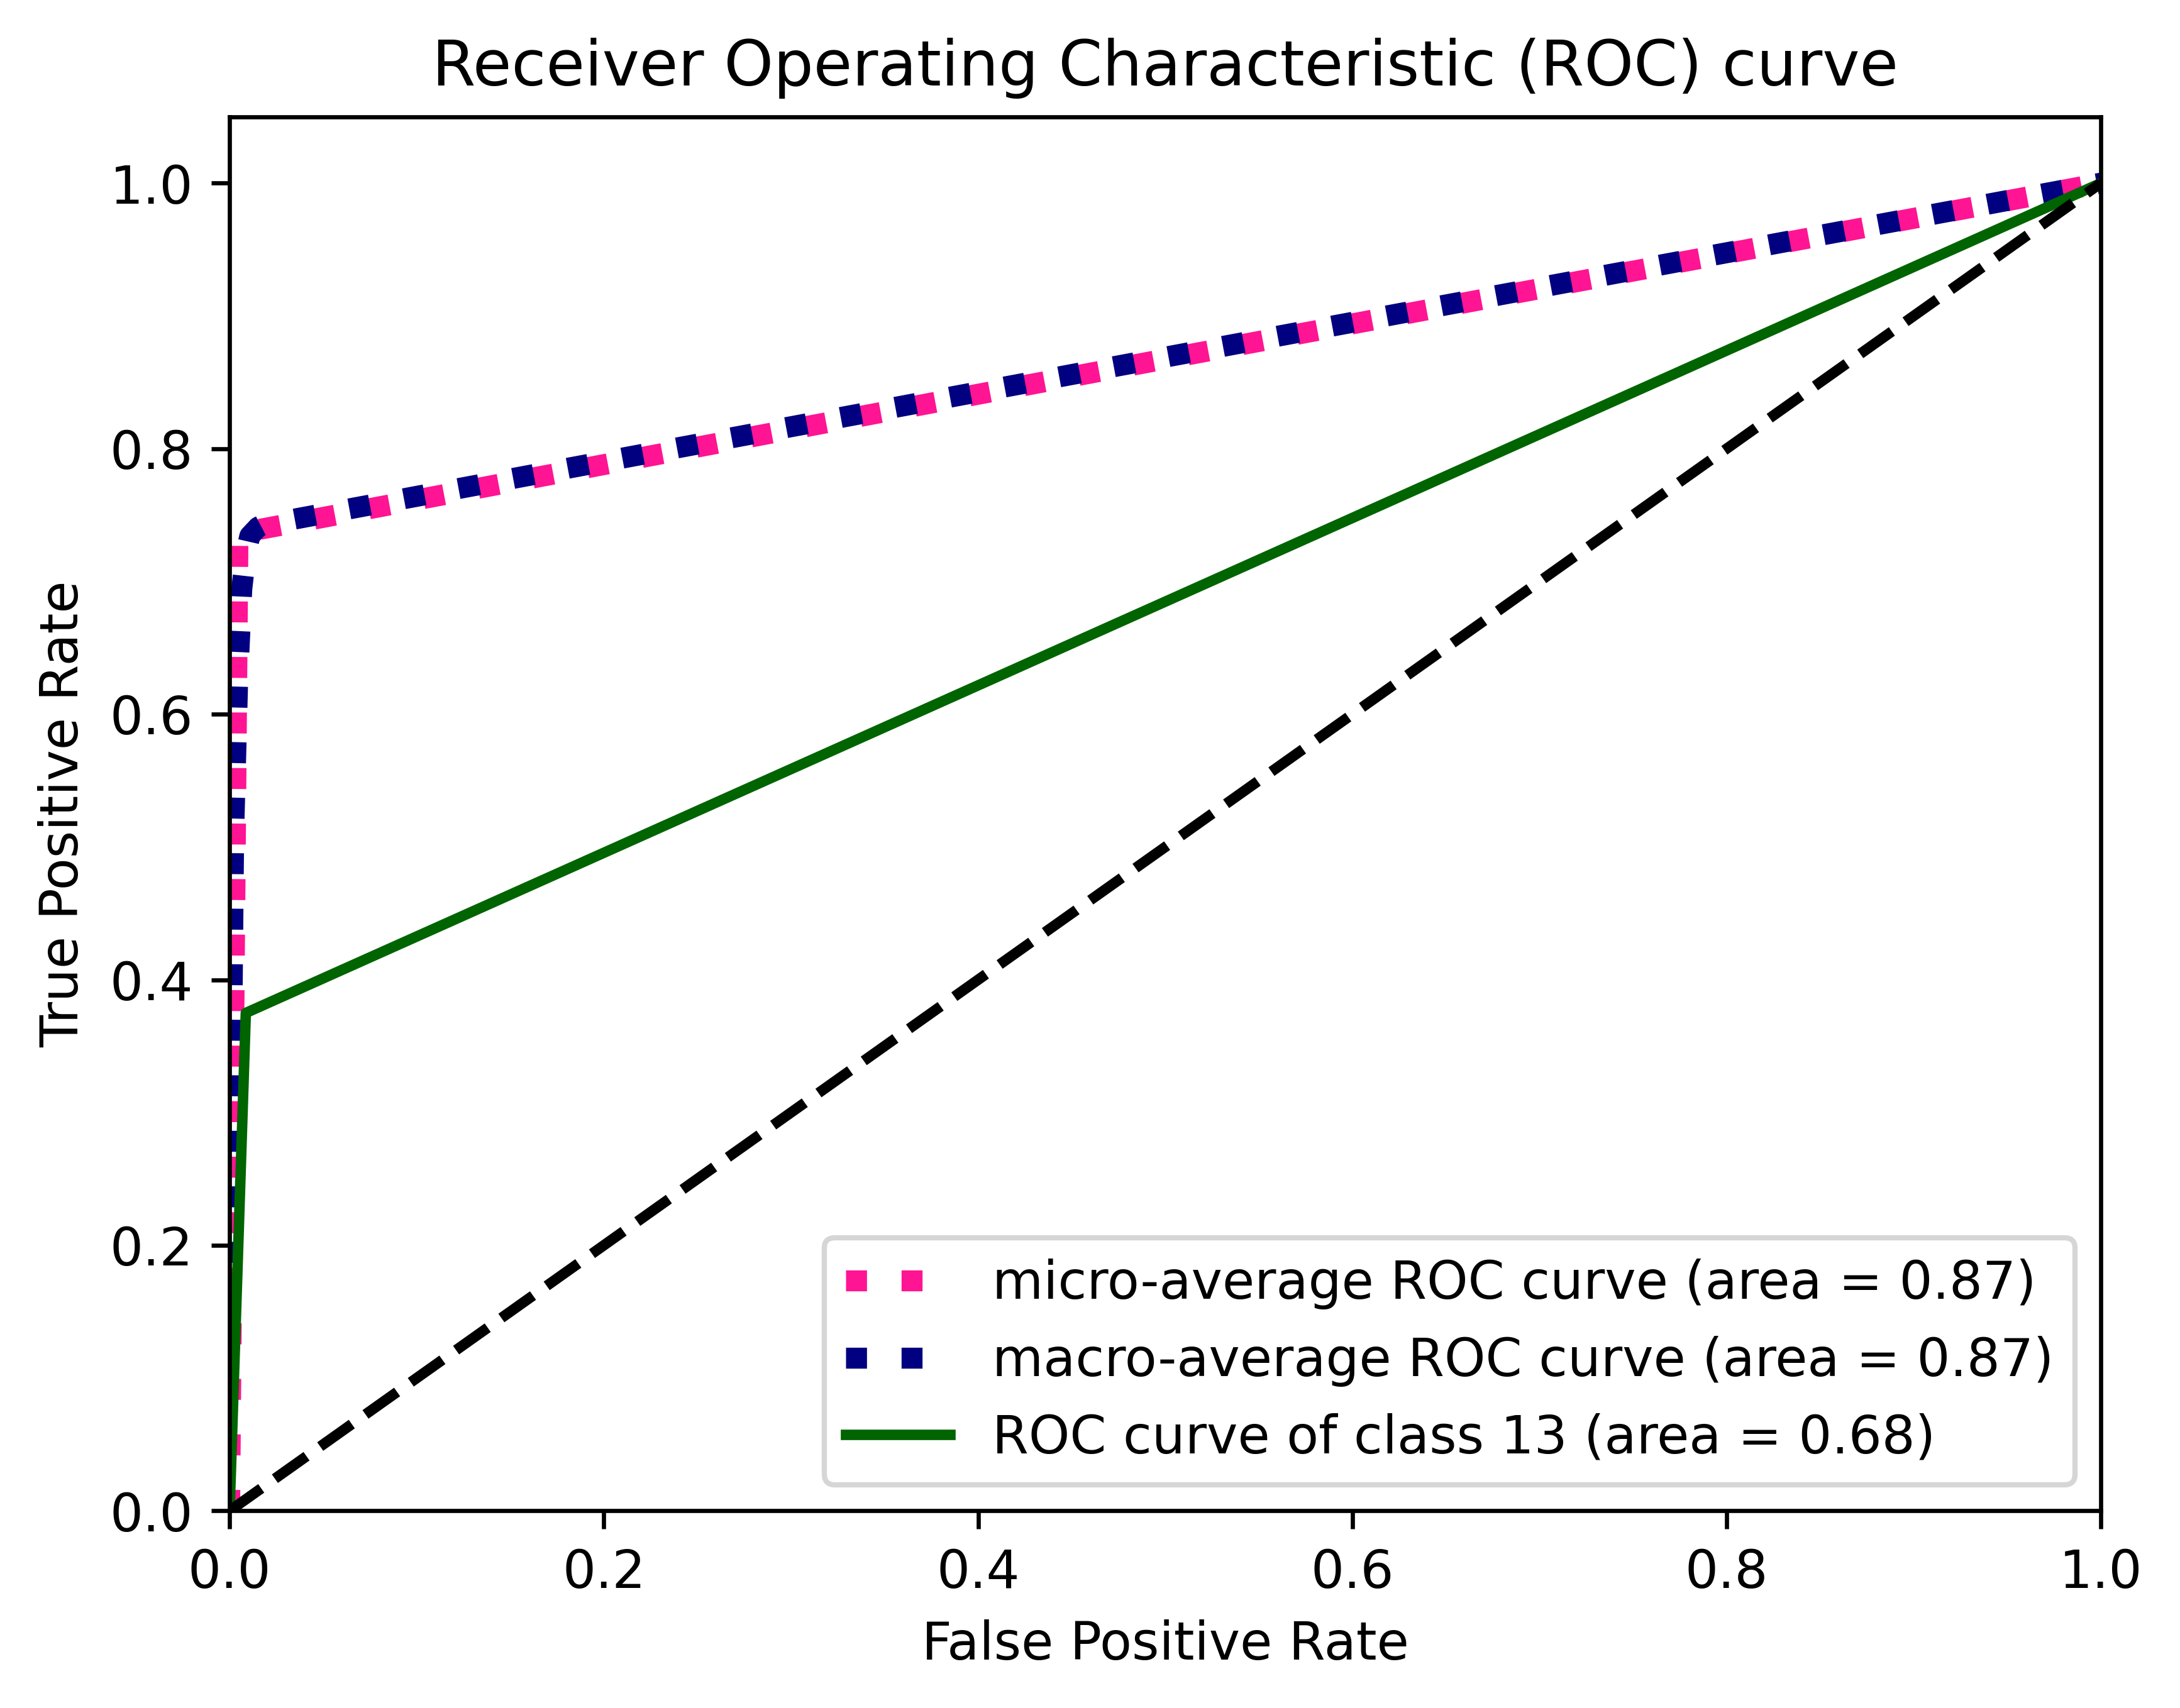

In [58]:
plot_roc_curve(y_test, predicted_classes,13)